# Imports

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# Sequences

Let's build a Gaussian sin function from which we will sample.

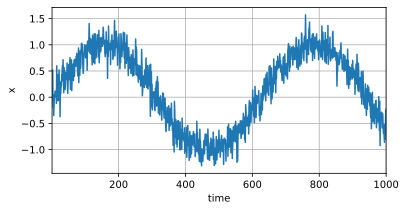

In [32]:
class Data(d2l.DataModule):
    def __init__(self, batch_size = 16, T = 1000, num_train=600, tau = 4):
        self.save_hyperparameters()
        self.time = torch.arange(
            start=1,
            end=T+1,
            dtype=torch.float32
        )
        self.x = torch.sin(0.01*self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Let's model this as a $\tau^{th}$-order Markov problem, by creating 600 samples of length $\tau$:

In [33]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
    print(features)
    self.features = torch.stack(features, 1)
    print(self.features)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    print(self.labels)
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In [34]:
data.get_dataloader(False)
print(data.x)

[tensor([ 0.0935, -0.0597,  0.5195, -0.1981,  0.0063, -0.3493, -0.1171,  0.0495,
         0.0183,  0.1167,  0.0274,  0.0023,  0.0529, -0.1182,  0.5986,  0.1517,
        -0.0672,  0.4311,  0.1732, -0.0616,  0.0663,  0.5208,  0.1913,  0.1938,
        -0.3706,  0.2920,  0.0668,  0.2490,  0.2169,  0.4296,  0.4463,  0.6013,
         0.3118,  0.7145,  0.3827,  0.0864,  0.5663,  0.3112,  0.5026,  0.1461,
         0.2061,  0.3674,  0.4703,  0.3825,  0.3404,  0.6521,  0.4652,  0.0768,
         0.3165,  0.4922,  0.6232,  0.3328,  0.3854,  0.6927,  0.7547,  0.1509,
         0.6010,  0.6027,  0.7139,  0.1285,  0.3643,  0.6311,  0.4917,  0.4883,
         0.3186,  0.6363,  0.7106,  0.4014,  0.7201,  0.6857,  0.6386,  0.5901,
         0.7785,  0.7411,  0.8378,  0.6894,  0.5247,  0.4095,  0.4782,  0.9400,
         0.2795,  0.8524,  0.6231,  0.4179,  0.8883,  0.5472,  0.6001,  0.9094,
         1.0295,  0.9752,  0.8328,  1.0100,  0.6578,  0.4552,  0.5234,  0.8339,
         0.8073,  0.9074,  0.9986,  0.8

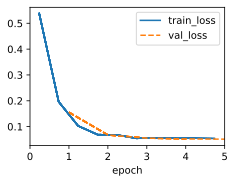

In [37]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

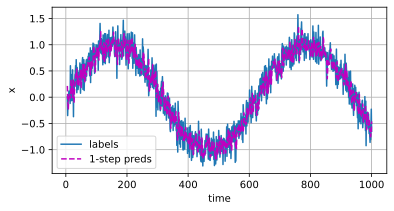

In [38]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

We can now try to make a $k$-step ahead prediction:

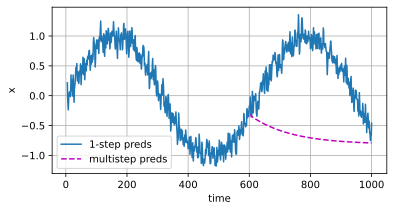

In [39]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1))
    )
    
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train + data.tau:]],
         [onestep_preds, multistep_preds[data.num_train + data.tau:]],
         'time', 'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

These terrible results are due to error accumulation. We can try with different values of k:

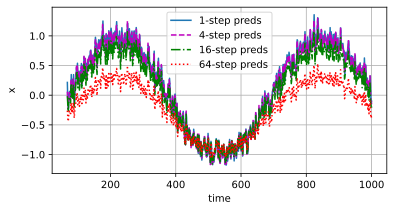

In [42]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i + data.T - data.tau - k + 1])
    
    # The (i+tau)-th element stores the (i+1) - step ahead predictions

    for i in range(k):
        preds = model(torch.stack(features[i : i + data.tau], 1))
        features.append(preds.reshape(-1))

    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau + steps[-1] - 1:],
         [preds[k-1].detach().numpy() for k in steps],
         'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

We can only go up to 4-step ahead preds.

# Converting raw text into sequence data

This, essentially, consists of converting sentences into tokens and indexing them to a dictionary, in order to obtain a string of numbers rather than a string of words.

In [43]:
import collections
import random
import re
import torch
from d2l import torch as d2l

Let's read the raw text into a string:

In [44]:
class TimeMachine(d2l.DataModule):      #@save
    """The Time Machine dataset"""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt',
                             self.root, '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
        
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

Let's ignore punctuation and capitalization.

In [45]:
@d2l.add_to_class(TimeMachine)      #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokenization

The following tokenization takes place on characters.

In [46]:
@d2l.add_to_class(TimeMachine)      #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '